<a href="https://colab.research.google.com/github/hanhluukim/replication-topic-modelling-in-embedding-space/blob/main/etm_in_julia/ETM_in_julia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installieren Julia auf dem Colab**

In [2]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.6/julia-1.6.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

# **Wichtiger-Schritt: im Laufzeit-Einstellung, wählen Julia und GPU (optional**
1. Erst nach diesem Schritt wird Julia nutzbar für Colab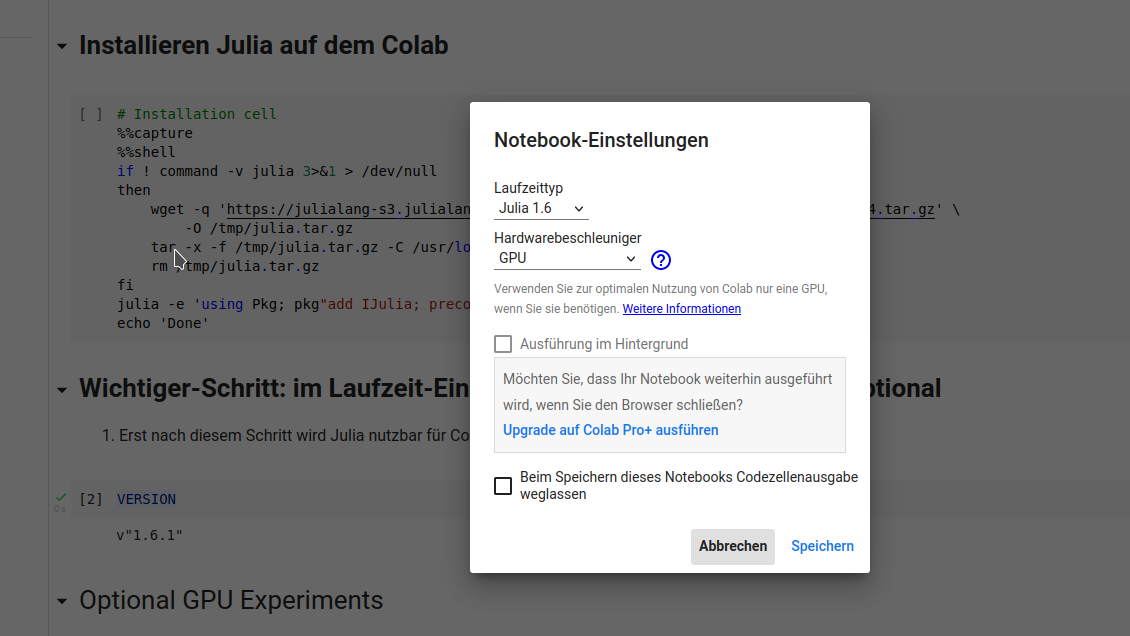

In [2]:
VERSION

v"1.6.1"

# Optional GPU Experiments

In [3]:
using Pkg
Pkg.add(["BenchmarkTools", "CUDA"])


using BenchmarkTools, CUDA

if has_cuda_gpu()
  print("The GPU device is:", CUDA.device())
end

The GPU device is:CuDevice(0)

In [4]:
mcpu = rand(2^10, 2^10)
@benchmark mcpu*mcpu

BenchmarkTools.Trial: 73 samples with 1 evaluation.
 Range (min … max):  64.348 ms … 110.497 ms  ┊ GC (min … max): 0.00% … 2.62%
 Time  (median):     66.008 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   69.096 ms ±   8.605 ms  ┊ GC (mean ± σ):  0.69% ± 1.52%

  ▄▆█                                                           
  ████▆▄▅▅▃▁▃▁▁▃▁▁▁▁▁▁▁▁▃▃▁▄▁▁▁▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▃ ▁
  64.3 ms         Histogram: frequency by time          102 ms <

 Memory estimate: 8.00 MiB, allocs estimate: 2.

In [5]:
println("The CuArrray operation should take around 0.5 ms(excluding CUDA downloading time which is a one time process), and should be much faster. If so, the GPU is working.")
mgpu = cu(mcpu)
@benchmark CUDA.@sync mgpu*mgpu

The CuArrray operation should take around 0.5 ms(excluding CUDA downloading time which is a one time process), and should be much faster. If so, the GPU is working.


BenchmarkTools.Trial: 2821 samples with 1 evaluation.
 Range (min … max):  1.608 ms …   4.088 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.736 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.758 ms ± 126.003 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

            ▂▂▅▆██▆█▇▆▅▃▁▂                                     
  ▁▁▁▁▂▄▅▇▆████████████████▇▇▅▅▄▃▄▄▃▃▄▃▃▄▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁ ▄
  1.61 ms         Histogram: frequency by time        2.02 ms <

 Memory estimate: 256 bytes, allocs estimate: 9.

# **Importieren von gebrauchten Paketten für die Implementierung**

In [ ]:
start_time = now()

In [6]:
using Pkg
Pkg.add(["BenchmarkTools", "CUDA", "Flux", "TextAnalysis"])

In [7]:
Pkg.add("MAT")

In [8]:
Pkg.add("DataLoaders")

In [9]:
Pkg.add("Torch")

In [10]:
Pkg.add("HTTP")

In [11]:
using BenchmarkTools, CUDA
using Flux, TextAnalysis
using MAT
using DataLoaders
using Torch
using Torch: torch
using HTTP

In [ ]:
print("used time for import: " * string(now()-start_time))

# **Wichtig: Hochladen die vorbereiteten Dateien aus dem Projekt-Repo auf Colab**


*   prepared_data/bow_train.mat
*   prepared_data/id2word.mat
*   prepared_data/vocab_embedding.txt

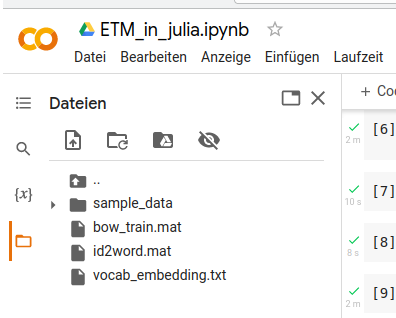





# **Lesen Vokabular: id2word**

In [22]:
id2word = matread("/content/id2word.mat")
#println(id2word["id"])
#println(id2word["word"])
temp = Dict()
for i in id2word["id"]
  temp[i] = id2word["word"][i+1]
end
id2word = temp

Dict{Any, Any} with 348 entries:
  56  => "technology"
  35  => "information"
  60  => "end"
  220 => "truth"
  308 => "project"
  67  => "buy"
  215 => "live"
  73  => "wrong"
  319 => "windows"
  251 => "hear"
  115 => "big"
  112 => "ram"
  185 => "thought"
  333 => "sci"
  86  => "public"
  168 => "person"
  207 => "run"
  263 => "stuff"
  242 => "university"
  183 => "wrote"
  224 => "taking"
  177 => "contact"
  12  => "institute"
  75  => "related"
  23  => "early"
  ⋮   => ⋮

# **Lesen vorverarbeitete BoW-Repräsentationen aus der Datei: prepared_data/bow_train.mat**


1.   Zuerst werden die vorverarbeiteten Dateien auf diesem Colab hochladen
2.   Listeneintrag



In [25]:
function covert_to_bows(data, vocab_size, normalize_data)
  # covert
  n_docs = length(data["tokens"]) #list of [list of token-ids] = n_docs
  # matrix in julia V*D
  bows = zeros(Float64, vocab_size, n_docs)
  #print(size(bows))
  for docid in 1:n_docs
    doc_tokens = data["tokens"][docid]
    doc_counts = data["counts"][docid]
    for (index, token_id) in enumerate(doc_tokens)
      #replace zeros with count
      bows[token_id+1, docid] = doc_counts[index]
    end
  end

  doc_bow_sums = sum(bows, dims =1)
  # normalize
  if normalize_data
    #println("\n normalized")
    bows = bows ./ doc_bow_sums
  end
  #println(size(bows))
  return bows
end


# loading files
bow_train = matread("/content/bow_train.mat")["train"]
#bow_train["train"]["tokens"]
#bow_train["train"]["counts"]

batch_size = 50
vocab_size = length(keys(id2word))
print("vocab-size: " * string(vocab_size) * "\n") 

normalize_data = true
normalized_data = covert_to_bows(bow_train, vocab_size, normalize_data)
dataloader = DataLoader(normalized_data, batch_size)
print("check n-batches: " * string(length(dataloader)) * "\n")
for bow_doc_batch in dataloader
    println(size(bow_doc_batch))
end

vocab-size: 348
check n-batches: 3
(348, 50)
(348, 50)
(348, 39)


# **Lesen Word-Embedding word2vec aus der Datei: prepared_data/vocab_embedding.txt**

In [28]:
embeddings = []
open("/content/vocab_embedding.txt") do file
  data = readlines(file)
  for line in data
    word, vector = split(line, "\t")
    vector = split(vector, " ")
    _vector = []
    for e in vector
      push!(_vector, parse(Float64, e))
    end
    push!(embeddings, _vector)
  end
end
#println(embeddings)
println("number of words in vocabulary: " * string(length(embeddings)))
print("dimension of word-embedding: " * string(length(embeddings[1])))

number of words in vocabulary: 348
dimension of word-embedding: 300

# **Implementieren von ETM Modell**

# **Evaluieren von Topics mittels folgenden Evaluationmaßen**